In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int']#, 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
tam_janela = n_variaveis*janela
n_entradas = n_variaveis * janela + 2 #ncont, valor e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 1

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
print(inputs['preco'][0:2])
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1

#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
    
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imean ) / istd #normaliza prs
    
mini_batch_size = int(dias*batch*0.1)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    3907.5
1    3900.0
Name: preco, dtype: float64


D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = 3
        self.action_size = 3
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        #model.add(Dense(256, activation='relu')) #camada escondida
        #model.add(Dense(256, activation='relu')) #camada escondida
        model.add(Dense(32, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        #sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        #model.compile(loss='mse', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(n_variaveis*janela)
        self.prox_janela_precos = np.zeros(n_variaveis*janela)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict(self.state) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        x = []
        y = []
        for acao, reward, estado, prox_estado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado)[0])) #pega valor que quer chegar

            target_f = self.model.predict(estado) 
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x.append(estado[0])
            y.append(target_f[0])
            
        self.model.fit(np.asarray(x), np.asarray(y), epochs=1, verbose=0) #treina modelo
        
    def tira_ultima_janela(self):
        if self.janela_precos.shape[0] > self.janela * self.n_variaveis:
            self.janela_precos = self.janela_precos[self.n_variaveis:] #tira os ultimos precos
    
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.next_state, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5888      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1419      
Total params: 171,787
Trainable params: 171,787
Non-trainable params: 0
_________________________________________________________________


In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def obter_acao(ncont):
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -10 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    lucro = 0.
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 10e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia], steps[dia+1] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.janela_precos = np.delete(np.insert(modelo.janela_precos,shp,np.concatenate(ultimos_precos.values).tolist()),[0,l])
        modelo.state = np.reshape(np.concatenate((modelo.janela_precos, [ncont/lim_cont, valor])), (1,n_entradas)) #adiciona na variavel de estado      
        
        acao = obter_acao(ncont)        
        ncont, valor, posicao, reward = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor if valor==-10 else valor*pstd+pmean
        #p=precos['preco'][step]*pstd+pmean
        #print("acao={0}; ncont={1}; valor={2}; preco={3}; posicao={4}; lucro={5}; reward={6}".format(acao, ncont, v, p, posicao, lucro, reward))   

        if step == (steps[dia] - 1): #se ultimo step do dia
            done = True     
            prox_precos = np.zeros(n_variaveis)
            modelo.prox_janela_precos = np.delete(np.insert(modelo.prox_janela_precos,shp,prox_precos),[0,l])
        else:
            prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
            modelo.prox_janela_precos = np.delete(np.insert(modelo.prox_janela_precos,shp,np.concatenate(prox_precos.values).tolist()),[0,l]) 
            
        modelo.next_state = np.reshape(np.concatenate((modelo.prox_janela_precos, [ncont/lim_cont, valor])), (1,n_entradas)) #adiciona na variavel de estado      
        modelo.remember(acao, posicao/posicao_max, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        
    #fim do dia
    lucro += posicao

    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( 0, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


resultado da epoca 0 = 959.26 Epsilon = 0.050
1
0
resultado da epoca 1 = 946.54 Epsilon = 0.050
1
0
resultado da epoca 2 = 1124.42 Epsilon = 0.050
1
0
resultado da epoca 3 = 540.32 Epsilon = 0.050
1
0
resultado da epoca 4 = 730.48 Epsilon = 0.050
1
0
resultado da epoca 5 = 432.90 Epsilon = 0.050
1
0
resultado da epoca 6 = 1352.16 Epsilon = 0.050
1
0
resultado da epoca 7 = 264.72 Epsilon = 0.050
1
0
resultado da epoca 8 = 621.54 Epsilon = 0.050
1
0
resultado da epoca 9 = 1386.24 Epsilon = 0.050
1
0
resultado da epoca 10 = 478.36 Epsilon = 0.050
1
0
resultado da epoca 11 = 447.76 Epsilon = 0.050
1
0
resultado da epoca 12 = 966.24 Epsilon = 0.050
1
0
resultado da epoca 13 = 615.18 Epsilon = 0.050
1
0
resultado da epoca 14 = 1008.06 Epsilon = 0.050
1
0
resultado da epoca 15 = 874.12 Epsilon = 0.050
1
0
resultado da epoca 16 = 644.28 Epsilon = 0.050
1
0
resultado da epoca 17 = 697.30 Epsilon = 0.050
1
0
resultado da epoca 18 = 1346.10 Epsilon = 0.050
1
0
resultado da epoca 19 = 729.28 Epsil

resultado da epoca 159 = 200.34 Epsilon = 0.050
1
0
resultado da epoca 160 = 624.44 Epsilon = 0.050
1
0
resultado da epoca 161 = 1090.80 Epsilon = 0.050
1
0
resultado da epoca 162 = 1593.08 Epsilon = 0.050
1
0
resultado da epoca 163 = 422.46 Epsilon = 0.050
1
0
resultado da epoca 164 = 1203.96 Epsilon = 0.050
1
0
resultado da epoca 165 = 383.82 Epsilon = 0.050
1
0
resultado da epoca 166 = 915.48 Epsilon = 0.050
1
0
resultado da epoca 167 = 1040.94 Epsilon = 0.050
1
0
resultado da epoca 168 = 221.56 Epsilon = 0.050
1
0
resultado da epoca 169 = 364.42 Epsilon = 0.050
1
0
resultado da epoca 170 = 699.74 Epsilon = 0.050
1
0
resultado da epoca 171 = 1056.24 Epsilon = 0.050
1
0
resultado da epoca 172 = 1228.22 Epsilon = 0.050
1
0
resultado da epoca 173 = 532.60 Epsilon = 0.050
1
0
resultado da epoca 174 = 1508.52 Epsilon = 0.050
1
0
resultado da epoca 175 = 950.48 Epsilon = 0.050
1
0
resultado da epoca 176 = 724.12 Epsilon = 0.050
1
0
resultado da epoca 177 = 906.10 Epsilon = 0.050
1
0
resul

resultado da epoca 317 = 976.86 Epsilon = 0.050
1
0
resultado da epoca 318 = 1085.04 Epsilon = 0.050
1
0
resultado da epoca 319 = 1604.42 Epsilon = 0.050
1
0
resultado da epoca 320 = 1498.52 Epsilon = 0.050
1
0
resultado da epoca 321 = 773.82 Epsilon = 0.050
1
0
resultado da epoca 322 = 1682.00 Epsilon = 0.050
1
0
resultado da epoca 323 = 904.30 Epsilon = 0.050
1
0
resultado da epoca 324 = 892.46 Epsilon = 0.050
1
0
resultado da epoca 325 = 641.70 Epsilon = 0.050
1
0
resultado da epoca 326 = 994.88 Epsilon = 0.050
1
0
resultado da epoca 327 = 1085.18 Epsilon = 0.050
1
0
resultado da epoca 328 = 1069.88 Epsilon = 0.050
1
0
resultado da epoca 329 = 1304.58 Epsilon = 0.050
1
0
resultado da epoca 330 = 1423.82 Epsilon = 0.050
1
0
resultado da epoca 331 = 1180.50 Epsilon = 0.050
1
0
resultado da epoca 332 = 1662.32 Epsilon = 0.050
1
0
resultado da epoca 333 = 1427.16 Epsilon = 0.050
1
0
resultado da epoca 334 = 1320.80 Epsilon = 0.050
1
0
resultado da epoca 335 = 1121.72 Epsilon = 0.050
1
0

resultado da epoca 473 = 594.42 Epsilon = 0.050
1
0
resultado da epoca 474 = 1298.98 Epsilon = 0.050
1
0
resultado da epoca 475 = 1321.26 Epsilon = 0.050
1
0
resultado da epoca 476 = 1035.94 Epsilon = 0.050
1
0
resultado da epoca 477 = 1008.06 Epsilon = 0.050
1
0
resultado da epoca 478 = 1243.68 Epsilon = 0.050
1
0
resultado da epoca 479 = 1048.84 Epsilon = 0.050
1
0
resultado da epoca 480 = 910.18 Epsilon = 0.050
1
0
resultado da epoca 481 = 262.76 Epsilon = 0.050
1
0
resultado da epoca 482 = 541.56 Epsilon = 0.050
1
0
resultado da epoca 483 = 402.46 Epsilon = 0.050
1
0
resultado da epoca 484 = 765.94 Epsilon = 0.050
1
0
resultado da epoca 485 = 1076.70 Epsilon = 0.050
1
0
resultado da epoca 486 = 1181.10 Epsilon = 0.050
1
0
resultado da epoca 487 = 554.12 Epsilon = 0.050
1
0
resultado da epoca 488 = 1160.64 Epsilon = 0.050
1
0
resultado da epoca 489 = 1234.88 Epsilon = 0.050
1
0
resultado da epoca 490 = 1088.38 Epsilon = 0.050
1
0
resultado da epoca 491 = 1393.84 Epsilon = 0.050
1
0


resultado da epoca 632 = 989.12 Epsilon = 0.050
1
0
resultado da epoca 633 = 1223.82 Epsilon = 0.050
1
0
resultado da epoca 634 = 1563.98 Epsilon = 0.050
1
0
resultado da epoca 635 = 1023.22 Epsilon = 0.050
1
0
resultado da epoca 636 = 884.44 Epsilon = 0.050
1
0
resultado da epoca 637 = 1383.82 Epsilon = 0.050
1
0
resultado da epoca 638 = 1294.28 Epsilon = 0.050
1
0
resultado da epoca 639 = 1524.14 Epsilon = 0.050
1
0
resultado da epoca 640 = 1200.50 Epsilon = 0.050
1
0
resultado da epoca 641 = 2073.08 Epsilon = 0.050
1
0
resultado da epoca 642 = 893.82 Epsilon = 0.050
1
0
resultado da epoca 643 = 1550.64 Epsilon = 0.050
1
0
resultado da epoca 644 = 802.76 Epsilon = 0.050
1
0
resultado da epoca 645 = 1005.20 Epsilon = 0.050
1
0
resultado da epoca 646 = 1313.82 Epsilon = 0.050
1
0
resultado da epoca 647 = 790.18 Epsilon = 0.050
1
0
resultado da epoca 648 = 951.70 Epsilon = 0.050
1
0
resultado da epoca 649 = 578.08 Epsilon = 0.050
1
0
resultado da epoca 650 = 1164.42 Epsilon = 0.050
1
0


resultado da epoca 788 = 1219.74 Epsilon = 0.050
1
0
resultado da epoca 789 = 1972.32 Epsilon = 0.050
1
0
resultado da epoca 790 = 1282.46 Epsilon = 0.050
1
0
resultado da epoca 791 = 592.46 Epsilon = 0.050
1
0
resultado da epoca 792 = 1580.80 Epsilon = 0.050
1
0
resultado da epoca 793 = 1158.06 Epsilon = 0.050
1
0
resultado da epoca 794 = 1408.08 Epsilon = 0.050
1
0
resultado da epoca 795 = 1199.28 Epsilon = 0.050
1
0
resultado da epoca 796 = 940.18 Epsilon = 0.050
1
0
resultado da epoca 797 = 1218.82 Epsilon = 0.050
1
0
resultado da epoca 798 = 1187.00 Epsilon = 0.050
1
0
resultado da epoca 799 = 1581.86 Epsilon = 0.050
1
0
resultado da epoca 800 = 1312.00 Epsilon = 0.050
1
0
resultado da epoca 801 = 1110.34 Epsilon = 0.050
1
0
resultado da epoca 802 = 1016.12 Epsilon = 0.050
1
0
resultado da epoca 803 = 674.42 Epsilon = 0.050
1
0
resultado da epoca 804 = 1007.32 Epsilon = 0.050
1
0
resultado da epoca 805 = 1422.76 Epsilon = 0.050
1
0
resultado da epoca 806 = 1455.64 Epsilon = 0.050


resultado da epoca 944 = 1536.86 Epsilon = 0.050
1
0
resultado da epoca 945 = 2408.70 Epsilon = 0.050
1
0
resultado da epoca 946 = -6.78 Epsilon = 0.050
0
1
resultado da epoca 947 = 1114.46 Epsilon = 0.050
1
0
resultado da epoca 948 = 1288.68 Epsilon = 0.050
1
0
resultado da epoca 949 = 1009.90 Epsilon = 0.050
1
0
resultado da epoca 950 = 2345.22 Epsilon = 0.050
1
0
resultado da epoca 951 = 1542.94 Epsilon = 0.050
1
0
resultado da epoca 952 = 1150.04 Epsilon = 0.050
1
0
resultado da epoca 953 = 1607.92 Epsilon = 0.050
1
0
resultado da epoca 954 = 579.00 Epsilon = 0.050
1
0
resultado da epoca 955 = 1304.44 Epsilon = 0.050
1
0
resultado da epoca 956 = 1244.28 Epsilon = 0.050
1
0
resultado da epoca 957 = 1743.68 Epsilon = 0.050
1
0
resultado da epoca 958 = 1115.04 Epsilon = 0.050
1
0
resultado da epoca 959 = 1503.08 Epsilon = 0.050
1
0
resultado da epoca 960 = 1782.16 Epsilon = 0.050
1
0
resultado da epoca 961 = 1180.36 Epsilon = 0.050
1
0
resultado da epoca 962 = 1690.96 Epsilon = 0.050


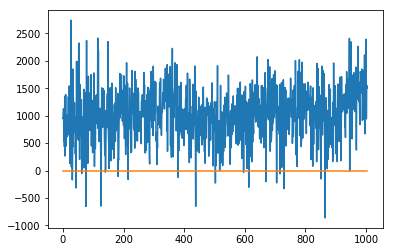

In [7]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    modelo.epsilon = 0.05
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            modelo.treina_modelo() #roda o modelo com toda a memoria da epoca
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            #if modelo.epsilon <= epsilon_min:
            #    modelo.epsilon = epsilon_min
            #else:
             #   modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca